# Tech Career Salary Analysis
> "A continuation of the previous post exploring salaries in the tech sector."

- toc: false
- branch: master
- badges: true 
- permalink: /career-salary-comparisons/
- comments: false
- hide: false
- categories: [Beginner, AdHoc Analysis]

This is a continuation of my [previous post]({% post_url 2022-05-02-salaryInfo %}), an exploration of what the data from [Levels.fyi](https://levels.fyi) says about the salary associated with various paths in the tech sector. In short, I built a [quick and dirty webscraper](https://github.com/borsboomT/levels_scraper/blob/main/levels_scraper.py) to collect all the salary data available on [Levels.fyi](https://levels.fyi) for the US tech sector. In my [previous post]({% post_url 2022-05-02-salaryInfo %}) I showed how the data was [aggregated](https://github.com/borsboomT/levels_scraper/blob/main/track_aggregator.py) and cleaned, and then made a brief observation that software engineers and data scientists make approximately the same amount of money.

There is so much more information that can be collected from the scraped data though. We have information on locations, companies, time spent with a given company, and more. We also have data for the following career tracks:
- Data Scientist
- Product Manager
- Recruiter
- Sales
- Software Engineer
- Software Engineering Manager
- Technical Program Manager

The objective of this post will be to explore the available data and see what conclusions can be drawn from it. We'll start by using the function we developed in my [previous post]({% post_url 2022-05-02-salaryInfo %}) to import and clean all the available data. For a thorough explanation of the thought process behind that function, check out that post!

In [1]:
# hide
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'


In [2]:
# hide_output
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns

DS_FILE_LOCATION = "https://raw.githubusercontent.com/borsboomT/levels_scraper/main/data/DataScientist_completeCSV.csv"
PM_FILE_LOCATION = "https://raw.githubusercontent.com/borsboomT/levels_scraper/main/data/ProductManager_completeCSV.csv"
REC_FILE_LOCATION = "https://raw.githubusercontent.com/borsboomT/levels_scraper/main/data/Recruiter_completeCSV.csv"
SAL_FILE_LOCATION = "https://raw.githubusercontent.com/borsboomT/levels_scraper/main/data/Sales_completeCSV.csv"
SWE_FILE_LOCATION = "https://raw.githubusercontent.com/borsboomT/levels_scraper/main/data/SoftwareEngineer_completeCSV.csv"
SWEM_FILE_LOCATION = "https://raw.githubusercontent.com/borsboomT/levels_scraper/main/data/SoftwareEngineeringManager_completeCSV.csv"
TPM_FILE_LOCATION = "https://raw.githubusercontent.com/borsboomT/levels_scraper/main/data/TechnicalProgramManager_completeCSV.csv"


In [3]:
def clean_salary_data(raw_df):

    # This ensures that the numerical columns are interpreted as numeric columns by
    # converting all N/A values to NaN.
    numeric_cols = [
        "Total Compensation",
        "Stock Comp",
        "Base Comp",
        "Bonus Comp",
        "YOE Total",
        "YOE At Company",
    ]
    raw_df[numeric_cols] = raw_df[numeric_cols].apply(
        pd.to_numeric, errors="coerce"
    )

    # We also round and convert the experience columns to integer values for easier grouping later on.
    exp_cols = ["YOE Total", "YOE At Company"]
    raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    raw_df.dropna(subset=exp_cols, how="all", inplace=True)

    raw_df[exp_cols] = raw_df[exp_cols].apply(np.round)
    raw_df[exp_cols] = raw_df[exp_cols].astype(int)

    YOE_vals = raw_df["YOE Total"].unique()

    cleaned_df_list = []
    for YOE in YOE_vals:
        # We filter the dataframe based on the total years of experience.
        df = raw_df[raw_df["YOE Total"] == YOE]

        # We get the upper and lower quantile data for the numeric columns.
        lower_quant = df.quantile(0.25)
        upper_quant = df.quantile(0.75)

        IQR = upper_quant - lower_quant
        cut_off = IQR * 1.5
        lower_cut_off, upper_cut_off = (
            lower_quant - cut_off,
            upper_quant + cut_off,
        )

        # We filter the data based on those quantiles
        quant_filter = (df[numeric_cols] > (lower_cut_off)) & (
            df[numeric_cols] < (upper_cut_off)
        )
        df = df[quant_filter.any(axis=1)]

        # We fill the NaN cells with the imputed median values
        df.fillna(df.median(), inplace=True)

        # We save the cleaned dataframe by adding it to a list
        cleaned_df_list.append(df)

    cleaned_df = pd.concat(cleaned_df_list)
    cleaned_df.reset_index(inplace=True, drop=True)

    return cleaned_df


cleaned_DS_df = clean_salary_data(
    pd.read_csv(DS_FILE_LOCATION)
)  # Data Scientist
cleaned_PM_df = clean_salary_data(
    pd.read_csv(PM_FILE_LOCATION)
)  # Product Manager
cleaned_REC_df = clean_salary_data(pd.read_csv(REC_FILE_LOCATION))  # Recruiter
cleaned_SAL_df = clean_salary_data(pd.read_csv(SAL_FILE_LOCATION))  # Sales
cleaned_SWE_df = clean_salary_data(
    pd.read_csv(SWE_FILE_LOCATION)
)  # Software Engineer
cleaned_SWEM_df = clean_salary_data(
    pd.read_csv(SWEM_FILE_LOCATION)
)  # Software Engineering Manager
cleaned_TPM_df = clean_salary_data(
    pd.read_csv(TPM_FILE_LOCATION)
)  # Technical Program Manager

clean_df_dict = {
    "DS": cleaned_DS_df,
    "PM": cleaned_PM_df,
    "REC": cleaned_REC_df,
    "SAL": cleaned_SAL_df,
    "SWE": cleaned_SWE_df,
    "SWEM": cleaned_SWEM_df,
    "TPM": cleaned_TPM_df,
}

focused_df_dict = {
    "DS": cleaned_DS_df,
    "SWE": cleaned_SWE_df,
    "SWEM": cleaned_SWEM_df,
}


# Raw Salary Comparison

We'll answer the simplest question first, which of these career paths makes the most money? The easiest way to answer this question is to plot the median values for each career path as a function of the total years of experience.

In [4]:
fig = go.Figure()

for df_key in clean_df_dict:
    df = clean_df_dict[df_key].copy(deep=True)

    df_grouped = df.groupby(["YOE Total"]).agg(
        ["mean", "count", "std", "median"]
    )

    fig.add_trace(
        go.Scatter(
            name=df_key,
            x=df_grouped.index,
            y=df_grouped["Total Compensation"]["median"],
            mode="lines",
        )
    )

fig.update_layout(
    xaxis_title="Total Years of Experience",
    yaxis_title="Median Total Yearly Compensation (USD)",
    showlegend=True,
)

fig.show()


A few things immediately jump out of this plot. The total compensation for recruiters falls far below the rest of the pack. Additionally, the total compensation for software engineering managers is far above the rest of the pack. Sales appears to lag behind the more technical roles to some extent until 9 years of experience, at which point it's fairly comparable to the bulk of the career paths. In the time that it takes to reach that point, however, a salesperson would had missed out on hundreds of thousands of dollars in income in comparison to a data scientist or software engineer. 

Looking closely, you can also see that the product manager and technical program manager roles lag slightly behind the data scientist and software engineer roles right up to about the 9 year mark. Most trends disappear beyond the 9 year mark for the bulk of the roles.

The remainder of this analysis will focus on the DS, and SWE roles for no reason other than those are the career paths I'm interested in.

# How Does FAANG compare?

Breaking the salary data down by company can offer some insight as to which companies offer the best compensation, whether that compensations comes in the form of base pay/stock/bonus, and whether or not the companies reward job hopping or tenure. A pair plot offers a good initial overview of the trends in the available data. The results of the pair plots actually looked the same for the career paths we're analysing, so only the SWE one is displayed below since that path has the largest amount of available data. I've also seen some stir about Microsoft entering the fray to be considered amongst the FAANG companies, so we'll throw them in to our FAANG analysis as well.

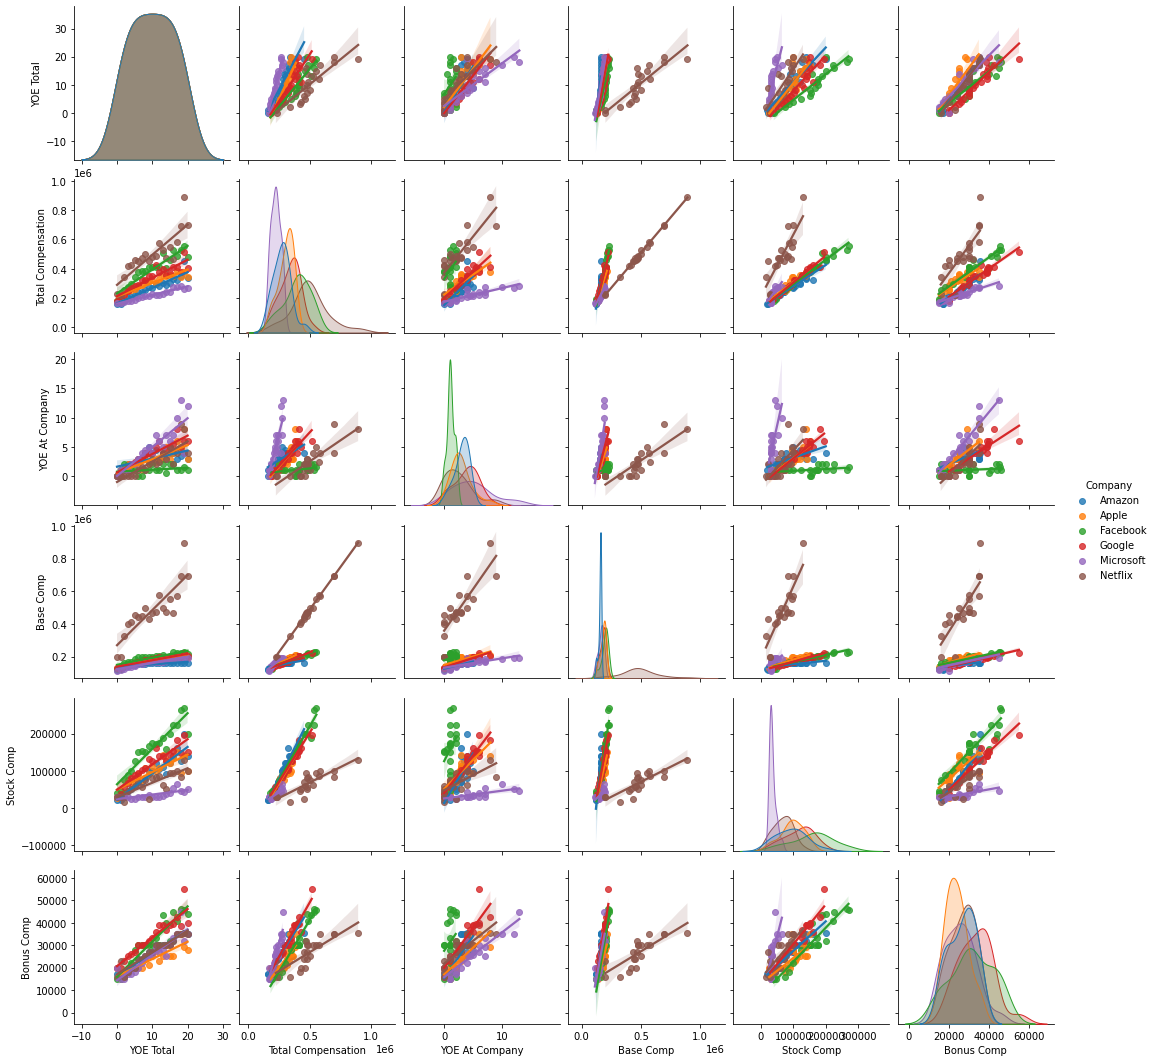

In [5]:
# hide_output
faang_companies = [
    "Facebook",
    "Amazon",
    "Apple",
    "Netflix",
    "Google",
    "Microsoft",
]

df = focused_df_dict["SWE"].copy(deep=True)

df_top = df[df["Company"].isin(faang_companies)]

df_top_grouped = df_top.groupby(["Company", "YOE Total"]).median()
df_top_grouped.reset_index(inplace=True)

ax = sns.pairplot(
    df_top_grouped,
    vars=[
        "YOE Total",
        "Total Compensation",
        "YOE At Company",
        "Base Comp",
        "Stock Comp",
        "Bonus Comp",
    ],
    kind="reg",
    hue="Company",
)


![pairplot image](https://github.com/borsboomT/fastpagesBlogBuilder/blob/master/images/faang_salary_pairplot.png?raw=true)

Immediately we see that Netflix appears to compensate far better than the other members of FAANG, and that most of this extra compensation comes in the form of increased base pay. The data also shows that Facebook offers more of its total compensation as stock than the other members, and that both Google and Facebook offer a significant portion of their total compensation as a bonus. Another thing we can see is that Microsoft appears to offer the lowest salary amongst the group, and they appear to have people staying on the longesst. We'll take a closer look at the relationship between YOE at a company and total compensation in a moment.

Let's take a closer look at how the median total compensation looks for each of the FAANG companies as a function of time for both DS and SWE.

In [6]:
def plot_median_salaries_companies(career_path, company_list, plot_title):

    df = focused_df_dict[career_path].copy(deep=True)

    df_top = df[df["Company"].isin(company_list)]

    df_top_grouped = df_top.groupby(["Company", "YOE Total"]).agg(
        ["mean", "count", "std", "median"]
    )
    df_top_grouped.reset_index(inplace=True)

    fig = go.Figure()

    for company in company_list:
        company_grouped_df = df_top_grouped[
            df_top_grouped["Company"] == company
        ]

        fig.add_trace(
            go.Scatter(
                name="{}".format(company),
                x=company_grouped_df["YOE Total"],
                y=company_grouped_df["Total Compensation"]["median"],
                mode="lines",
            )
        )

    fig.update_layout(
        title=plot_title,
        xaxis_title="Total Years of Experience",
        yaxis_title="Median Total Yearly Compensation (USD)",
        showlegend=True,
    )

    fig.show()


plot_median_salaries_companies(
    "DS", faang_companies, "DS FAANG Median Salaries"
)
plot_median_salaries_companies(
    "SWE", faang_companies, "SWE FAANG Median Salaries"
)


Netflix is the clear leader in terms of total compensation for both career paths, just like we saw in the pair plot. It appears that for the remainder of the FAANG companies, the competition is fierce on the data science side while there appears to be a clear pecking order on the software engineering side.

One major criticism of FAANG is that much of the total compensation comes in the form of stock and bonuses, and that in a bear market the total compensation of these companies could tank. Lets take a look at just how much of the total compensation is provided through non-guaranteed means at FAANG companies.



In [7]:
def plot_stock_bonus_ratio_companies(
    career_path, company_list, plot_title, plot_type
):

    df = focused_df_dict[career_path].copy(deep=True)

    df_top = df[df["Company"].isin(company_list)]

    df_top_grouped = df_top.groupby(["Company", "YOE Total"]).agg(
        ["mean", "count", "std", "median"]
    )
    df_top_grouped.reset_index(inplace=True)

    fig = go.Figure()

    for company in company_list:
        company_grouped_df = df_top_grouped[
            df_top_grouped["Company"] == company
        ]
        company_stock_ratio = (
            company_grouped_df["Stock Comp"]["median"]
            / company_grouped_df["Total Compensation"]["median"]
        )
        company_bonus_ratio = (
            company_grouped_df["Bonus Comp"]["median"]
            / company_grouped_df["Total Compensation"]["median"]
        )

        if plot_type == "stock":
            y_vals = company_stock_ratio
            axis_title = "Stock"
        elif plot_type == "bonus":
            y_vals = company_bonus_ratio
            axis_title = "Bonus"

        fig.add_trace(
            go.Scatter(
                name="{}".format(company),
                x=company_grouped_df["YOE Total"],
                y=y_vals,
                mode="lines",
            )
        )

    fig.update_layout(
        title=plot_title,
        xaxis_title="Total Years of Experience",
        yaxis_title="Proportion of Total Compensation Contributed by {}".format(
            axis_title
        ),
        showlegend=True,
    )

    fig.show()


plot_stock_bonus_ratio_companies(
    "DS", faang_companies, "DS FAANG Stock Salary Proportion", "stock"
)
plot_stock_bonus_ratio_companies(
    "SWE", faang_companies, "SWE FAANG Stock Salary Proportion", "stock"
)

plot_stock_bonus_ratio_companies(
    "DS", faang_companies, "DS FAANG Bonus Salary Proportion", "bonus"
)
plot_stock_bonus_ratio_companies(
    "SWE", faang_companies, "SWE FAANG Bonus Salary Proportion", "bonus"
)


Here we highlight just how heavily skewed towards stock many of the FAANG companies can become, especially later in your career, for both data scientists and software engineers. That said, Netflix appears to do the best job at providing the bulk of an employee's salary through base pay.

# Job Hopping vs Company Tenure

People constantly make the argument that the fastest way to increase your salary in the tech sector is to jump between companies, and that staying with one company isn't rewarded. Let's take a look at what the data says about that claim. In order to evaluate the statement we'll plot total compensation as a function of total years of experience, but split the data by the number of years of experience at a given company. When plotting this data, using all available values for YOE at a company made the plot unreadable. The plot below is restricted to 5 years of experience and below, but highlights the same trends.

In [8]:
def plot_YOE_tenure_comparison(career_path, plot_title):

    df = focused_df_dict[career_path].copy(deep=True)

    df_top_grouped = df.groupby(["YOE At Company", "YOE Total"]).agg(
        ["mean", "count", "std", "median"]
    )
    df_top_grouped.reset_index(inplace=True)

    YOE_vals = range(0, 6)

    fig = go.Figure()

    for YOE in YOE_vals:
        # We only plot data for company tenure 5 years and below to improve
        # the readability of the plot.
        if YOE <= 5:
            YOE_grouped_df = df_top_grouped[
                df_top_grouped["YOE At Company"] == YOE
            ]

            fig.add_trace(
                go.Scatter(
                    name="{}".format(YOE),
                    x=YOE_grouped_df["YOE Total"],
                    y=YOE_grouped_df["Total Compensation"]["median"],
                    mode="lines",
                )
            )

    fig.update_layout(
        title=plot_title,
        xaxis_title="Total Years of Experience",
        yaxis_title="Median Total Yearly Compensation (USD)",
        legend_title_text="YOE at Company",
        showlegend=True,
    )

    fig.show()


plot_YOE_tenure_comparison("DS", "DS Company Tenure Comparison")
plot_YOE_tenure_comparison("SWE", "SWE Company Tenure Comparison")


It appears there is some truth to the claim that job hopping results in higher salary. The claim is especially true for the software engineering track, as the trace for 0 years of tenure at a company is frequently seen above the other traces in the plot. The truth is a little less clear for the data scientist career track, however there does appear to be an inclination for higher salaries at 0 years of tenure. 

One surprising thing about this plot is the data corresponding to people with more years of tenure at a company than they have experience in a particular job. These data points would indicate people transitioning between career paths while staying within the same company. It appears that if you already work for a tech company and are trying to make a career transition to data science or software engineering, the best move you have is to transition into your new role while working for the same company, and begin job hopping afterwards.

# Which Companies Pay the Most?

Some people are more interested in total compensation than the clout that goes along with working for a FAANG company. We should take a look at which companies pay the most regardless of clout, and see if FAANG is really all that when it comes to total compensation. We'll take a look at the top 10 companies for both data science and software engineering careers paths. We'll also be limiting this analysis to companies that have 30 or more entries in our datasets to ensure we have enough data to make some claims. Admittedly, the value of 30 is somewhat arbitrary but I will discuss that in a moment.

In [9]:
def get_top_compensation_companies(career_path, num_companies):

    df = focused_df_dict[career_path].copy(deep=True)

    top_companies = df.groupby(["Company"]).agg(
        ["mean", "count", "std", "median"]
    )
    top_companies.reset_index(inplace=True)
    top_companies = top_companies[
        top_companies["Total Compensation"]["count"] >= 30
    ]
    top_companies.sort_values(
        ("Total Compensation", "median"), ascending=False, inplace=True
    )
    top_companies = top_companies["Company"][:num_companies]

    return top_companies


top_DS_companies = get_top_compensation_companies("DS", 10)
plot_median_salaries_companies(
    "DS", top_DS_companies, "DS Top Company Median Salaries"
)

top_SWE_companies = get_top_compensation_companies("SWE", 10)
plot_median_salaries_companies(
    "SWE", top_SWE_companies, "SWE Top Company Median Salaries"
)


These plots are very messy, but what I wanted to highlight with them is that while for data scientists each of FAANG can be found in the top ten companies that is not the case for software engineers. FAANG is very poorly represented amongst the top paying companies for software engineers, with only Netflix appearing in the top ten. Also worth noting is that amongst the best compensating companies for software engineers, Netflix is definitely competitive but it's not like they're dominating the competition.

This just goes to show that while FAANG might seem shiny, the intensive hiring processes and increased stress load may not be worth it if your main goal is total compensation.

# What Role Does Location Play?

The last topic I'll address with this data is location. People talk a lot about where you need to move if you want a career in tech, and while remote work is becoming more and more normalized it's still worth looking at how employment location has historically affected total compensation. Let's group our data by location and sort by median salary to see which locations come out on top. We'll be restricting the plot to cities that have at least 10 entries to avoid any odd entries or outliers.

In [10]:
def get_top_compensation_locations(career_path, num_locations):

    df = focused_df_dict[career_path].copy(deep=True)

    top_locations = df.groupby(["Location"]).agg(
        ["mean", "count", "std", "median"]
    )
    top_locations.reset_index(inplace=True)
    top_locations = top_locations[
        top_locations["Total Compensation"]["count"] >= 10
    ]
    top_locations.sort_values(
        ("Total Compensation", "median"), ascending=False, inplace=True
    )
    top_locations = top_locations["Location"][:num_locations]

    return top_locations


def plot_median_salaries_locations(career_path, location_list, plot_title):

    df = focused_df_dict[career_path].copy(deep=True)

    df_top = df[df["Location"].isin(location_list)]

    df_top_grouped = df_top.groupby(["Location"]).agg(
        ["mean", "count", "std", "median"]
    )
    df_top_grouped.reset_index(inplace=True)

    fig = go.Figure()

    for location in location_list:
        location_grouped_df = df_top_grouped[
            df_top_grouped["Location"] == location
        ]

        fig.add_trace(
            go.Bar(
                name="{}".format(location),
                x=location_grouped_df["Location"],
                y=location_grouped_df["Total Compensation"]["median"],
            )
        )

    fig.update_layout(
        title=plot_title,
        yaxis_title="Median Total Yearly Compensation (USD)",
        showlegend=True,
    )

    fig.show()


top_DS_locations = get_top_compensation_locations("DS", 10)
plot_median_salaries_locations(
    "DS", top_DS_locations, "DS Top Location Median Salaries"
)

top_SWE_locations = get_top_compensation_locations("SWE", 10)
plot_median_salaries_locations(
    "SWE", top_SWE_locations, "SWE Top Location Median Salaries"
)


It's no surprise that in the top ten locations for both data scientists and software engineers we're mostly seeing Silicon Valley, the Greater Seattle Area. Los Gatos clearly takes the cake in terms of total compensation, however that's where the main headquarters of Netflix can be found. Let's do this again, but aggregate the Silicon Valley and Greater Seattle Area locations.

In [11]:
def aggregate_locations(df):
    silicon_valley_cities = "|".join(
        [
            "San Jose, CA",
            "Menlo Park, CA",
            "Palo Alto, CA",
            "Mountain View, CA",
            "Cupertino, CA",
            "Santa Clara, CA",
            "Redwood City, CA",
            "Sunnyvale, CA",
            "Los Gatos, CA",
            "San Mateo, CA",
            "San Bruno, CA",
        ]
    )

    san_francisco_cities = "|".join(["South San Francisco, CA"])

    seattle_area_cities = "|".join(
        ["Seattle, WA", "Kirkland, WA", "Redmond, WA", "Bellevue, WA"]
    )

    df["Location"] = df["Location"].str.replace(
        silicon_valley_cities, "Silicon Valley"
    )
    df["Location"] = df["Location"].str.replace(
        seattle_area_cities, "Greater Seattle Area"
    )
    df["Location"] = df["Location"].str.replace(
        san_francisco_cities, "San Francisco, CA"
    )

    return df


def get_top_compensation_locations_aggregated(career_path, num_locations):

    df = focused_df_dict[career_path].copy(deep=True)

    df = aggregate_locations(df)

    top_locations = df.groupby(["Location"]).agg(
        ["mean", "count", "std", "median"]
    )
    top_locations.reset_index(inplace=True)
    top_locations = top_locations[
        top_locations["Total Compensation"]["count"] >= 10
    ]
    top_locations.sort_values(
        ("Total Compensation", "median"), ascending=False, inplace=True
    )
    top_locations = top_locations["Location"][:num_locations]

    return top_locations


def plot_median_salaries_aggregated_locations(
    career_path, location_list, plot_title
):

    df = focused_df_dict[career_path].copy(deep=True)

    df = aggregate_locations(df)

    df_top = df[df["Location"].isin(location_list)]

    df_top_grouped = df_top.groupby(["Location"]).agg(
        ["mean", "count", "std", "median"]
    )
    df_top_grouped.reset_index(inplace=True)

    fig = go.Figure()

    for location in location_list:
        location_grouped_df = df_top_grouped[
            df_top_grouped["Location"] == location
        ]

        fig.add_trace(
            go.Bar(
                name="{}".format(location),
                x=location_grouped_df["Location"],
                y=location_grouped_df["Total Compensation"]["median"],
            )
        )

    fig.update_layout(
        title=plot_title,
        yaxis_title="Median Total Yearly Compensation (USD)",
        showlegend=True,
    )

    fig.show()


top_DS_locations_aggregated = get_top_compensation_locations_aggregated(
    "DS", 10
)
plot_median_salaries_aggregated_locations(
    "DS",
    top_DS_locations_aggregated,
    "DS Top Aggregated Location Median Salaries",
)

top_SWE_locations_aggregated = get_top_compensation_locations_aggregated(
    "SWE", 10
)
plot_median_salaries_aggregated_locations(
    "SWE",
    top_SWE_locations_aggregated,
    "SWE Top Aggregated Location Median Salaries",
)


San Francisco and Silicon valley top the charts for both data scientist and software engineering career paths. Interestingly enough the Greater Seattle Area appears to be a great spot for data scientists, but just barely squeaks into the top ten for software engineers. Beyond those observations we get an interesting mishmash of cities from CA, MA, NJ, and NY.

One very important thing to note here is that based on this plot the median salaries for software engineers appear to be quite a bit higher than for data scientists. That is an odd observation given that the analysis from my [previous post]({% post_url 2022-05-02-salaryInfo %}) indicated that they shouldn't be that different. The thing that this plot isn't taking into account is that having more years of experience results in higher salary, and there are much more data points for software engineers at later in the careers than there are for data scientists. That makes this plot appear to show a higher salary range for software engineers, but that's not actually an inference we can make from this plot.

In [12]:
def count_later_career_datapoints(career_path, start_year):

    df = focused_df_dict[career_path].copy(deep=True)
    df_grouped = df.groupby(["YOE Total"]).agg(["count"])
    num_data_points = df_grouped[df_grouped.index >= start_year][
        "Total Compensation"
    ]["count"].sum()

    return num_data_points


num_late_career_DS_datapoints = count_later_career_datapoints("DS", 15)
num_late_career_SWE_datapoints = count_later_career_datapoints("SWE", 15)

print(
    "Number of late career DS data points: {}".format(
        num_late_career_DS_datapoints
    )
)
print(
    "Number of late career SWE data points: {}".format(
        num_late_career_SWE_datapoints
    )
)


Number of late career DS data points: 80
Number of late career SWE data points: 2947


# Wrapping Up
Anyway, that's all I've got for this time. The data I used for this analysis can all be found [on my github](https://github.com/borsboomT/levels_scraper/tree/main/data). I encourage everyone who reads this to download and and see what you can find for yourself. If you think I've gotten something wrong here, prove it to me! I'm always happy to be proven wrong, it gives me an opportunity to learn. :D